In [11]:
# NEWS SUMMARIZATION PROJECT - TEXT RANK (with safe fallback for sentence tokenization)

import re
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
import nltk
import numpy as np
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [12]:
try:
    nltk.download('punkt', quiet=True)
except Exception:
    # ignore download errors; we'll fallback later
    pass

In [13]:
reference_text = """
Google announced the release of its latest artificial intelligence model on Tuesday,
designed to help developers build applications faster and with improved accuracy.
The new model features enhanced natural language understanding, reduced latency,
and improved energy efficiency. According to Google, the update will allow developers
to integrate advanced AI features—such as text summarization,
code generation, and conversational agents—directly into their products with minimal setup.
Industry experts predict that this new release will intensify competition among major tech companies,
as businesses increasingly rely on AI-driven solutions. Google plans to roll out additional tools and training resources later this year.
"""

In [14]:
try:
    # Preferred: NLTK sentence tokenizer
    sentences = nltk.sent_tokenize(reference_text)
    if not sentences:
        raise LookupError("nltk returned empty sentences")
except Exception:
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())
    sentences = [s.strip() for s in sentences if s and len(s.strip()) > 0]

In [15]:
if not sentences:
    sentences = [text.strip()]

In [16]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sentences)

In [17]:
similarity_matrix = (X * X.T).toarray()
np.fill_diagonal(similarity_matrix, 0)

In [18]:
graph = nx.from_numpy_array(similarity_matrix)
scores = nx.pagerank(graph)

In [19]:
ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
n_summary = min(2, len(sentences))
summary = " ".join([s for _, s in ranked_sentences[:n_summary]])

print("----- Summary -----")
print(summary)

----- Summary -----

Google announced the release of its latest artificial intelligence model on Tuesday, 
designed to help developers build applications faster and with improved accuracy. According to Google, the update will allow developers 
to integrate advanced AI features—such as text summarization, 
code generation, and conversational agents—directly into their products with minimal setup.


In [20]:

from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score(reference_text, summary)
print(scores)


{'rouge1': Score(precision=1.0, recall=0.5148514851485149, fmeasure=0.6797385620915033), 'rouge2': Score(precision=0.9803921568627451, recall=0.5, fmeasure=0.662251655629139), 'rougeL': Score(precision=1.0, recall=0.5148514851485149, fmeasure=0.6797385620915033)}


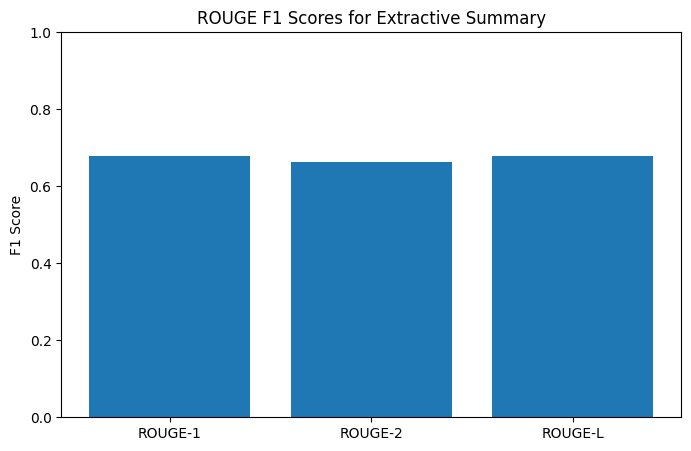

In [21]:
import matplotlib.pyplot as plt

metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
f1_scores = [
    scores['rouge1'].fmeasure,
    scores['rouge2'].fmeasure,
    scores['rougeL'].fmeasure
]

plt.figure(figsize=(8,5))
plt.bar(metrics, f1_scores)
plt.title("ROUGE F1 Scores for Extractive Summary")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.show()


In [22]:
from IPython.display import HTML, display
text = summary.replace("\n", "<br>")

html = f"""
<div style="
    border-radius:20px;
    padding:24px;
    background:linear-gradient(135deg, #0f172a, #1e293b);
    color:#f8fafc;
    box-shadow:0 10px 30px rgba(0,0,0,0.45);
    max-width:900px;
    border:1px solid rgba(148,163,184,0.18);
    font-family: 'Segoe UI', sans-serif;
">

  <div style="display:flex; align-items:center; gap:10px; margin-bottom:10px;">
      <span style="font-size:26px;">🗞️</span>
      <h3 style="
          margin:0;
          font-size:24px;
          color:#38bdf8;
          font-weight:700;
          letter-spacing:0.4px;
      ">
          Final Summary — TL;DR
      </h3>
  </div>

  <p style="
      color:#e2e8f0;
      font-size:15.5px;
      line-height:1.7;
      margin:0 0 15px 0;
  ">
    {text}
  </p>

  <p style="margin-top:5px;font-size:14px;color:#94a3b8;">
    <strong style="color:#38bdf8;">Method:</strong> TextRank &nbsp;•&nbsp;
    <strong style="color:#38bdf8;">ROUGE-1 F1:</strong> {scores['rouge1'].fmeasure:.2f}
  </p>

  <button onclick="navigator.clipboard.writeText(`{summary.replace('`','\\`')}`)"
          style="
              margin-top:12px;
              padding:10px 16px;
              border-radius:10px;
              border:none;
              background:linear-gradient(135deg,#3b82f6,#60a5fa);
              color:white;
              cursor:pointer;
              font-weight:600;
              font-size:14px;
              box-shadow:0 0 14px rgba(96,165,250,0.55);
              transition:0.25s;
          "
          onmouseover="this.style.boxShadow='0 0 20px rgba(96,165,250,0.95)'"
          onmouseout="this.style.boxShadow='0 0 14px rgba(96,165,250,0.55)'"
  >
      📋 Copy Summary
  </button>

</div>
"""

display(HTML(html))
